In [4]:
import db
import models
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm

from db import session
from models import *

from tokenizer import Tokenizer
from sklearn.decomposition import PCA

from pathlib import Path
from gensim.models import KeyedVectors

we = Path('/home/mquezada/phd/multimedia-summarization/data/word_embeddings/ft_alltweets_model.vec')
model = KeyedVectors.load_word2vec_format(we.as_posix())

tokenizer = Tokenizer()

pd.options.display.max_colwidth = 0

logger = logging.getLogger(__name__)
logging.basicConfig(format='%(asctime)s | %(name)s | %(levelname)s : %(message)s', level=logging.INFO)

2017-12-26 11:56:15,792 | summa.preprocessing.cleaner | INFO : 'pattern' package not found; tag filters are not available for English
2017-12-26 11:56:15,800 | gensim.models.keyedvectors | INFO : loading projection weights from /home/mquezada/phd/multimedia-summarization/data/word_embeddings/ft_alltweets_model.vec
2017-12-26 11:57:36,560 | gensim.models.keyedvectors | INFO : loaded (1076139, 100) matrix from /home/mquezada/phd/multimedia-summarization/data/word_embeddings/ft_alltweets_model.vec
2017-12-26 11:57:36,561 | tokenizer | INFO : Loading spacy model
2017-12-26 11:57:38,603 | tokenizer | INFO : Model Loaded


In [53]:
%load_ext rpy2.ipython

from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Avg fasttext full tweets

In [118]:
event_id = 8
n_tweets = 10

Get all tweets of event:

In [119]:
tweets = db.get_tweets(event_id)
id_tweet = dict()

for tweet in tweets:
    id_tweet[tweet.tweet_id] = tweet
# urls = session.query(ShortURL, ExpandedURL).join(ExpandedURL, ShortURL.expanded_id == ExpandedURL.id).yield_per(1000)

- filter out tweets con muchos hashtags o urls
- Create dictionary of short_url => tweet_ids


In [120]:
from collections import defaultdict

url_tweet = defaultdict(list)
tweets_wo_url = list()

filtered_tweets = []

for tweet_id, (n_ht, n_urls) in tqdm(zip([t.tweet_id for t in tweets], 
                                         tokenizer.count_special_tokens([tweet.text for tweet in tweets])), 
                                     desc="filtering hashtags",
                                     total=len(tweets)):
    if n_ht < 4 and n_urls < 3:
        filtered_tweets.append(tweet_id)

for tweet_id in tqdm(filtered_tweets):
    tweet = id_tweet[tweet_id]
    urls_ = [token.text for token in tokenizer.nlp(tweet.text) if token.like_url]
    for u in urls_:
        url_tweet[u].append(tweet.tweet_id)
    if not urls_:
        tweets_wo_url.append(tweet.tweet_id)

100%|██████████| 26349/26349 [02:49<00:00, 155.83it/s]


Load the dictionary short_url => expanded_url

In [122]:
"""exp_tweets = defaultdict(list)

for short, expanded in tqdm(urls):
    tweet_ids = url_tweet.get(short.short_url)
    
    if tweet_ids:
        exp_tweets[expanded.expanded_clean] = tweet_ids
"""  

filename = '../urls.csv'
urls = pd.read_csv(filename)
short_exp = dict()

for row in tqdm(urls.iterrows(), total=urls.shape[0]):
    short_exp[row[1]['short_url']] = row[1]['expanded_clean']

100%|██████████| 190081/190081 [00:11<00:00, 17063.50it/s]


Use the previous dict to create new dict expanded_url => tweet_ids, plus tweet_id => tweet_id (for tweets w/o url)

**TODO** Additionaly: add tweet_id\* => list_of tweet_ids which retweets tweet_id\*

In [123]:
exp_tweets = defaultdict(list)

for short, expanded in tqdm(short_exp.items()):
    tweet_ids = url_tweet.get(short)
    if tweet_ids:
        exp_tweets[expanded] = tweet_ids
        
for t in tweets_wo_url:
    exp_tweets[t] = [t]
    
print(len(exp_tweets))

100%|██████████| 189998/189998 [00:00<00:00, 1779296.13it/s]

7333


Create avg fasttext vectors for each document:

In [124]:
vectors = []
docs = []
tweets = []

for doc_id, tweet_ids in tqdm(exp_tweets.items(), total=len(exp_tweets)):
    texts = [id_tweet[tweet_id].text for tweet_id in tweet_ids if tweet_id in id_tweet]
    vector = [model[token] for text in texts for token in tokenizer.tokenize(text) if token in model]
    
    if vector:
        vectors.append(np.mean(vector, axis=0))
        docs.append(doc_id)
        for text in texts:
            tweets.append((doc_id, text))

100%|██████████| 7333/7333 [01:08<00:00, 106.77it/s]


In [125]:
len(tweets)

10707

Save vectors, doc_ids (urls) and tweets (url, text)

In [126]:
pd.DataFrame(vectors).to_csv('libya_vectors_full.tsv', sep='\t', header=False, index=False)
pd.DataFrame(docs).to_csv('libya_doc_ids_full.tsv', sep='\t', header=False, index=False)
pd.DataFrame(tweets).to_csv('libya_tweets_full.tsv', sep='\t', header=False, index=False)

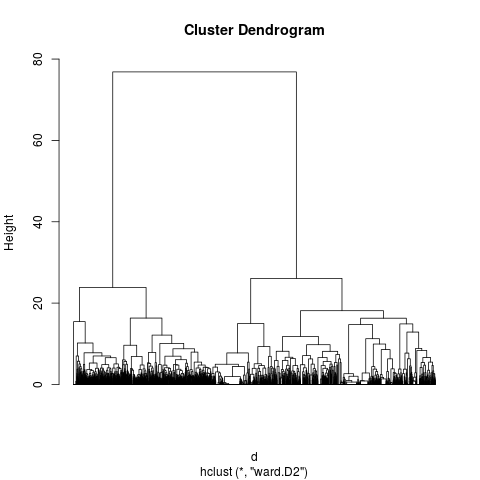

In [133]:
%%R -o texts_1

library(data.table)
library(cluster)
library(factoextra)
library(ggplot2)
library(proxy)

setwd('/home/mquezada/phd/multimedia-summarization/_new/data/vectors/')
set.seed(123)

vectors <- fread('libya_vectors_full.tsv', sep='\t', header=F)
docs <- fread('libya_doc_ids_full.tsv', sep='\t', header=F)
texts <- fread('libya_tweets_full.tsv', sep='\t', header=F)

d <- dist(vectors, method='euclidean')
hc <- hclust(d, method = 'ward.D2')
plot(hc, hang=-1, labels = F)

labels <- cutree(hc, k=2)
docs.f <- docs[labels == 2]
texts_1 <- texts[docs.f, on="V1"]

In [134]:
label_1 = pandas2ri.ri2py(texts_1)[["V2"]]
label_1["V2"].value_counts().to_csv('label1.txt')
# label_1.to_csv('label1.txt')

# Avg fasttext docs-only tweets (with non-URL tweets)

Elegir representante por cada documento:

In [23]:
import random

rep_tweets = []
doc_ids = []

for exp_url, tweet_ids in exp_tweets.items():
    tweets_ = [id_tweet[id] for id in tweet_ids]
    originals = [t for t in tweets_ if not t.is_a_retweet]
    
    if originals:
        rep_tweets.append(random.choice(originals))
    else:
        rep_tweets.append(random.choice(tweets_))
    doc_ids.append(exp_url)

Create avg fasttext vectors for each document:

In [27]:
vectors = []
tweets = []

for doc_id, tweet in tqdm(zip(doc_ids, rep_tweets)):
    text = tweet.text
    vector = [model[token] for token in tokenizer.tokenize(text) if token in model]
    
    if vector:
        vectors.append(np.mean(vector, axis=0))
        tweets.append((doc_id, text))

7333it [00:47, 154.95it/s]


In [28]:
len(tweets)

7326

Save vectors, doc_ids (urls) and tweets (url, text)

In [44]:
pd.DataFrame(vectors).to_csv('data/vectors/libya_vectors_rep.tsv', sep='\t', header=False, index=False)
pd.DataFrame(tweets).to_csv('data/vectors/libya_tweets_rep.tsv', sep='\t', header=False, index=False)

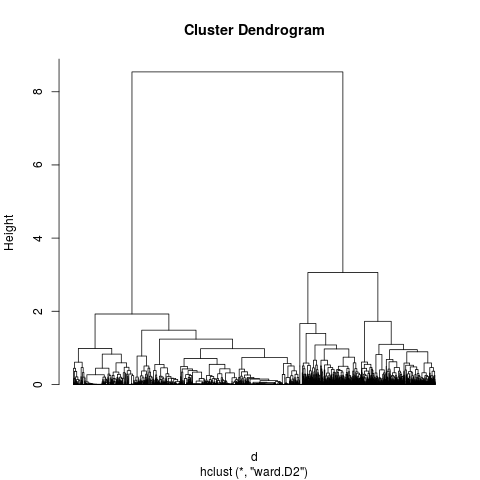

In [93]:
%%R -o texts_2

library(data.table)
library(cluster)
library(factoextra)
library(ggplot2)
library(proxy)

setwd('/home/mquezada/phd/multimedia-summarization/_new/data/vectors/')
set.seed(123)

vectors <- fread('libya_vectors_rep.tsv', sep='\t', header=F)
texts <- fread('libya_tweets_rep.tsv', sep='\t', header=F)

d <- dist(vectors, method='cosine')
hc <- hclust(d, method = 'ward.D2')
plot(hc, hang=-1, labels = F)

labels <- cutree(hc, k=2)
texts_2 <- texts[labels == 2]

In [94]:
label_1 = pandas2ri.ri2py(texts_2)[["V2"]]
label_1.to_csv('label1.txt')

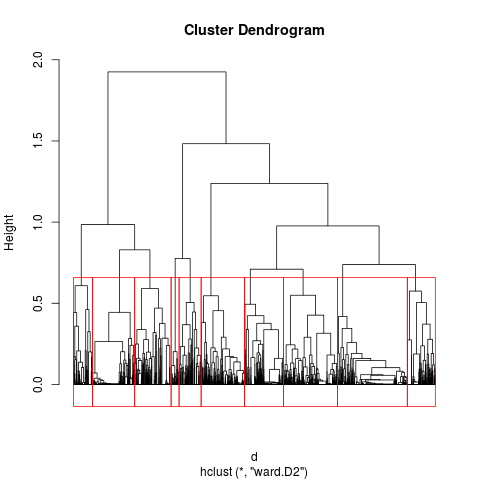

In [95]:
%%R -o clusters
f.vectors <- vectors[labels == 2]
d <- dist(f.vectors, method='cosine')

hc <- hclust(d, method="ward.D2")
plot(hc, hang=-1, labels=F)
rect.hclust(hc, k=10)
labels <- cutree(hc, k=10)
texts_2$label <- labels
clusters <- texts_2

In [96]:
clusters = pandas2ri.ri2py(clusters)

In [97]:
for l in range(1, 11): 
    print(l)
    print(clusters[clusters["label"] == l][["V2"]].sample(10))
    print("=" * 100)
    print()
    print()

1
                                                                                                                                          V2
1431  Libyan security official says gunmen have taken hostages and killed three guards at a luxury hotel in #Tripoli                        
1466  #Libya forces surround luxury hotel in #Tripoli where gunmen have taken hostages after car bomb attack - Reuters/AP                   
1721  TRIPOLI, Libya (@AP) - Libyan security official says gunmen at luxury Tripoli hotel take hostages; 3 guards killed.                   
2892  UPDATE: Libyan security official says gunmen at luxury Tripoli hotel take hostages; 3 guards killed, 5 foreigners reported dead. - @AP
1473  RT @SkyNewsBreak: Libyan security official says gunmen have taken hostages and killed three guards at a luxury hotel in #Tripoli      
2275  BREAKING: Libyan security official says gunmen take hostages at luxury Tripoli hotel, at least 3 guards killed                        
1579  BREAK

# Avg fasttext full tweets (sin tweets w/o URL)

In [99]:
exp_tweets = defaultdict(list)

for short, expanded in tqdm(short_exp.items()):
    tweet_ids = url_tweet.get(short)
    if tweet_ids:
        exp_tweets[expanded] = tweet_ids
    
print(len(exp_tweets))


100%|██████████| 189998/189998 [00:00<00:00, 1677495.58it/s]

3383


In [100]:
vectors = []
docs = []
tweets = []

for doc_id, tweet_ids in tqdm(exp_tweets.items(), total=len(exp_tweets)):
    texts = [id_tweet[tweet_id].text for tweet_id in tweet_ids if tweet_id in id_tweet]
    vector = [model[token] for text in texts for token in tokenizer.tokenize(text) if token in model]
    
    if vector:
        vectors.append(np.mean(vector, axis=0))
        docs.append(doc_id)
        for text in texts:
            tweets.append((doc_id, text))


 21%|██▏       | 719/3383 [00:09<00:35, 74.36it/s]
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/mquezada/anaconda3/envs/ams/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/mquezada/anaconda3/envs/ams/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/mquezada/anaconda3/envs/ams/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 3383/3383 [00:42<00:00, 80.36it/s]


In [104]:
pd.DataFrame(vectors).to_csv('libya_vectors_full_no_url.tsv', sep='\t', header=False, index=False)
pd.DataFrame(docs).to_csv('libya_doc_ids_full_no_url.tsv', sep='\t', header=False, index=False)
pd.DataFrame(tweets).to_csv('libya_tweets_full_no_url.tsv', sep='\t', header=False, index=False)

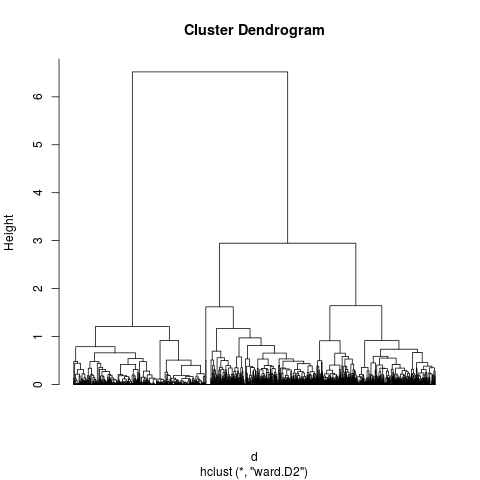

In [116]:
%%R -o texts_1

library(data.table)
library(cluster)
library(factoextra)
library(ggplot2)
library(proxy)

setwd('/home/mquezada/phd/multimedia-summarization/_new/data/vectors/')
set.seed(123)

vectors <- fread('libya_vectors_full_no_url.tsv', sep='\t', header=F)
docs <- fread('libya_doc_ids_full_no_url.tsv', sep='\t', header=F)
texts <- fread('libya_tweets_full_no_url.tsv', sep='\t', header=F)

d <- dist(vectors, method='cosine')
hc <- hclust(d, method = 'ward.D2')
plot(hc, hang=-1, labels = F)

labels <- cutree(hc, k=2)
docs.f <- docs[labels == 2]
texts_1 <- texts[docs.f, on="V1"]

#texts_2 <- texts[labels == 2]

In [117]:
label_1 = pandas2ri.ri2py(texts_1)[["V2"]]
label_1["V2"].value_counts().to_csv('label1.txt')
# label_1.to_csv('label1.txt')

---

# event_id=11 Parsons Green Explosion; ALL-tweets--FULL-docs

In [135]:
event_id = 11

Get all tweets of event:

In [137]:
tweets = db.get_tweets(event_id)
id_tweet = dict()

for tweet in tweets:
    id_tweet[tweet.tweet_id] = tweet

Get urls from db:

In [141]:
urls = session.query(ShortURL, ExpandedURL).join(ExpandedURL, ShortURL.expanded_id == ExpandedURL.id).yield_per(1000)

- filter out tweets con muchos hashtags o urls
- Create dictionary of short_url => tweet_ids


In [142]:
from collections import defaultdict

url_tweet = defaultdict(list)
tweets_wo_url = list()

filtered_tweets = []

for tweet_id, (n_ht, n_urls) in tqdm(zip([t.tweet_id for t in tweets], 
                                         tokenizer.count_special_tokens([tweet.text for tweet in tweets])), 
                                     desc="filtering hashtags",
                                     total=len(tweets)):
    if n_ht < 4 and n_urls < 3:
        filtered_tweets.append(tweet_id)

for tweet_id in tqdm(filtered_tweets):
    tweet = id_tweet[tweet_id]
    urls_ = [token.text for token in tokenizer.nlp(tweet.text) if token.like_url]
    for u in urls_:
        url_tweet[u].append(tweet.tweet_id)
    if not urls_:
        tweets_wo_url.append(tweet.tweet_id)

100%|██████████| 109863/109863 [14:59<00:00, 122.14it/s]


Load the dictionary short_url => expanded_url

Use the previous dict to create new dict expanded_url => tweet_ids, plus tweet_id => tweet_id (for tweets w/o url)

**TODO** Additionaly: add tweet_id\* => list_of tweet_ids which retweets tweet_id\*

**update**: la base de datos actual no tiene la info del retweet ;(

In [143]:
exp_tweets = defaultdict(list)

for short, expanded in tqdm(urls):
    tweet_ids = url_tweet.get(short.short_url)
    
    if tweet_ids:
        exp_tweets[expanded.expanded_clean] = tweet_ids

for t in tweets_wo_url:
    exp_tweets[t] = [t]
    
print(len(exp_tweets))

4951885it [02:38, 31219.28it/s]

25224


Create avg fasttext vectors for each document:

In [144]:
ft_vectors = []
doc_ids = []
id_texts = []

for doc_id, tweet_ids in tqdm(exp_tweets.items(), total=len(exp_tweets)):
    texts = [id_tweet[tweet_id].text for tweet_id in tweet_ids if tweet_id in id_tweet]
    vector = [model[token] for text in texts for token in tokenizer.tokenize(text) if token in model]
    
    if vector:
        ft_vectors.append(np.mean(vector, axis=0))
        doc_ids.append(doc_id)
        for text in texts:
            id_texts.append((doc_id, text))

100%|██████████| 25224/25224 [06:37<00:00, 63.42it/s]


In [147]:
len(ft_vectors)

25214

Save vectors, doc_ids (urls) and tweets (url, text)

In [148]:
pd.DataFrame(ft_vectors).to_csv('green_vectors_full.tsv', sep='\t', header=False, index=False)
pd.DataFrame(doc_ids).to_csv('green_doc_ids_full.tsv', sep='\t', header=False, index=False)
pd.DataFrame(id_texts).to_csv('green_tweets_full.tsv', sep='\t', header=False, index=False)

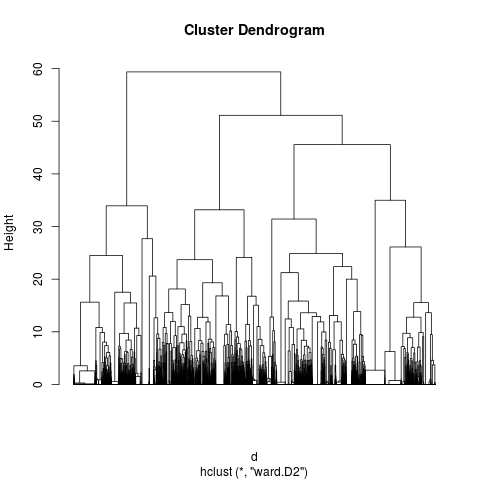

In [149]:
%%R -o texts_1

library(data.table)
library(cluster)
library(factoextra)
library(ggplot2)
library(proxy)

setwd('/home/mquezada/phd/multimedia-summarization/_new/data/vectors/')
set.seed(123)

vectors <- fread('green_vectors_full.tsv', sep='\t', header=F)
docs <- fread('green_doc_ids_full.tsv', sep='\t', header=F)
texts <- fread('green_tweets_full.tsv', sep='\t', header=F)

d <- dist(vectors, method='euclidean')
hc <- hclust(d, method = 'ward.D2')
plot(hc, hang=-1, labels = F)

labels <- cutree(hc, k=2)
docs.f <- docs[labels == 1]
texts_1 <- texts[docs.f, on="V1"]

In [153]:
%%R -o texts_1
docs.f <- docs[labels == 2]
texts_1 <- texts[docs.f, on="V1"]

In [154]:
label_1 = pandas2ri.ri2py(texts_1)[["V2"]]
label_1["V2"].value_counts().to_csv('label1.txt')
# label_1.to_csv('label1.txt')

---

# event_id=12 Spain Catalonia; ALL-tweets--FULL-docs

In [158]:
event_id = 10

Get all tweets of event:

In [175]:
tweets = db.get_tweets(event_id)
id_tweet = dict()

tweets = random.sample(tweets, 50000)

for tweet in tweets:
    id_tweet[tweet.tweet_id] = tweet
    
len(tweets)

50000

Get urls from db:

In [176]:
urls = session.query(ShortURL, ExpandedURL).join(ExpandedURL, ShortURL.expanded_id == ExpandedURL.id).yield_per(1000)

- filter out tweets con muchos hashtags o urls
- Create dictionary of short_url => tweet_ids


In [177]:
from collections import defaultdict

url_tweet = defaultdict(list)
tweets_wo_url = list()

filtered_tweets = []

for tweet_id, (n_ht, n_urls) in tqdm(zip([t.tweet_id for t in tweets], 
                                         tokenizer.count_special_tokens([tweet.text for tweet in tweets])), 
                                     desc="filtering hashtags",
                                     total=len(tweets)):
    if n_ht < 4 and n_urls < 3:
        filtered_tweets.append(tweet_id)

for tweet_id in tqdm(filtered_tweets):
    tweet = id_tweet[tweet_id]
    urls_ = [token.text for token in tokenizer.nlp(tweet.text) if token.like_url]
    for u in urls_:
        url_tweet[u].append(tweet.tweet_id)
    if not urls_:
        tweets_wo_url.append(tweet.tweet_id)


  5%|▌         | 2543/49242 [00:23<07:06, 109.51it/s]


 12%|█▏        | 5887/49242 [00:54<06:38, 108.83it/s]


 18%|█▊        | 9068/49242 [01:25<06:17, 106.32it/s]


 25%|██▍       | 12275/49242 [01:56<05:50, 105.58it/s]


 32%|███▏      | 15541/49242 [02:26<05:18, 105.78it/s]


 38%|███▊      | 18699/49242 [02:57<04:50, 105.11it/s]


 44%|████▍     | 21886/49242 [03:28<04:20, 104.92it/s]


 51%|█████     | 25193/49242 [03:59<03:48, 105.36it/s]


 57%|█████▋    | 28291/49242 [04:29<03:19, 104.81it/s]


 64%|██████▍   | 31527/49242 [05:00<02:48, 104.84it/s]


 71%|███████   | 34736/49242 [05:31<02:18, 104.78it/s]


 77%|███████▋  | 37744/49242 [06:02<01:50, 104.11it/s]


 83%|████████▎ | 40954/49242 [06:33<01:19, 104.21it/s]


 90%|████████▉ | 44185/49242 [07:03<00:48, 104.26it/s]


 97%|█████████▋| 47566/49242 [07:34<00:16, 104.69it/s]


100%|██████████| 49242/49242 [07:49<00:00, 104.84it/s]

Load the dictionary short_url => expanded_url

Use the previous dict to create new dict expanded_url => tweet_ids, plus tweet_id => tweet_id (for tweets w/o url)

**TODO** Additionaly: add tweet_id\* => list_of tweet_ids which retweets tweet_id\*

**update**: la base de datos actual no tiene la info del retweet ;(

In [178]:
exp_tweets = defaultdict(list)

for short, expanded in tqdm(urls):
    tweet_ids = url_tweet.get(short.short_url)
    
    if tweet_ids:
        exp_tweets[expanded.expanded_clean] = tweet_ids

for t in tweets_wo_url:
    exp_tweets[t] = [t]
    
print(len(exp_tweets))


0it [00:00, ?it/s]
3001it [00:00, 29783.30it/s]
7001it [00:00, 34682.79it/s]
12001it [00:00, 38219.93it/s]
17001it [00:00, 39517.70it/s]
22001it [00:00, 40202.41it/s]
26001it [00:00, 36518.84it/s]
30001it [00:00, 36322.67it/s]
34914it [00:00, 37700.16it/s]
38669it [00:01, 37148.74it/s]
42278it [00:01, 36984.32it/s]
46001it [00:01, 36944.40it/s]
51001it [00:01, 37346.47it/s]
55001it [00:01, 37447.43it/s]
59001it [00:01, 37539.82it/s]
63001it [00:01, 36522.54it/s]
67001it [00:01, 36544.15it/s]
71001it [00:01, 36623.36it/s]
75001it [00:02, 36753.54it/s]
80001it [00:02, 36985.14it/s]
84001it [00:02, 37016.51it/s]
88510it [00:02, 37357.28it/s]
92524it [00:02, 37212.12it/s]
96363it [00:02, 37199.14it/s]
100157it [00:03, 31671.06it/s]
104001it [00:03, 31857.97it/s]
109001it [00:03, 32347.27it/s]
114001it [00:03, 32743.11it/s]
118001it [00:03, 32917.53it/s]
123001it [00:03, 32520.90it/s]
127001it [00:03, 32553.70it/s]
132001it [00:04, 32819.34it/s]
135648it [00:04, 29863.13it/s]
140001it [00:

2197001it [01:16, 28532.93it/s]
2202001it [01:17, 28559.99it/s]
2207001it [01:17, 28586.17it/s]
2212001it [01:17, 28606.85it/s]
2217001it [01:17, 28629.64it/s]
2222001it [01:17, 28651.69it/s]
2227001it [01:17, 28674.97it/s]
2231401it [01:18, 28516.41it/s]
2237001it [01:18, 28544.77it/s]
2242001it [01:18, 28569.64it/s]
2247971it [01:18, 28609.27it/s]
2252574it [01:18, 28629.17it/s]
2257097it [01:18, 28618.26it/s]
2262001it [01:18, 28641.26it/s]
2267001it [01:19, 28666.33it/s]
2272001it [01:19, 28689.57it/s]
2276360it [01:19, 28538.48it/s]
2281001it [01:19, 28558.33it/s]
2286001it [01:19, 28578.50it/s]
2291001it [01:20, 28601.15it/s]
2296001it [01:20, 28623.07it/s]
2300842it [01:20, 28647.71it/s]
2305178it [01:20, 28662.37it/s]
2310001it [01:20, 28679.20it/s]
2315001it [01:21, 28545.67it/s]
2320001it [01:21, 28566.70it/s]
2325001it [01:21, 28585.90it/s]
2330001it [01:21, 28611.56it/s]
2335001it [01:21, 28634.84it/s]
2340447it [01:21, 28666.46it/s]
2345045it [01:21, 28669.99it/s]
2350001i

4341001it [02:34, 28021.15it/s]
4345001it [02:35, 28026.25it/s]
4348001it [02:35, 27950.15it/s]
4352001it [02:35, 27941.11it/s]
4356001it [02:35, 27946.87it/s]
4360001it [02:35, 27952.91it/s]
4364001it [02:36, 27959.29it/s]
4368001it [02:36, 27966.06it/s]
4372001it [02:36, 27971.67it/s]
4375431it [02:36, 27899.74it/s]
4379001it [02:36, 27903.36it/s]
4383001it [02:37, 27908.01it/s]
4387001it [02:37, 27912.86it/s]
4391001it [02:37, 27918.97it/s]
4395001it [02:37, 27925.30it/s]
4399001it [02:37, 27931.70it/s]
4402515it [02:38, 27860.51it/s]
4406001it [02:38, 27863.40it/s]
4410001it [02:38, 27868.51it/s]
4414001it [02:38, 27874.03it/s]
4418001it [02:38, 27879.38it/s]
4422001it [02:38, 27884.06it/s]
4425333it [02:38, 27868.88it/s]
4428152it [02:39, 27789.80it/s]
4432001it [02:39, 27794.80it/s]
4436001it [02:39, 27801.57it/s]
4440001it [02:39, 27797.37it/s]
4444001it [02:39, 27802.77it/s]
4448001it [02:39, 27807.19it/s]
4452001it [02:40, 27810.99it/s]
4455161it [02:40, 27735.22it/s]
4457545i

18676


Create avg fasttext vectors for each document:

In [179]:
ft_vectors = []
doc_ids = []
id_texts = []

for doc_id, tweet_ids in tqdm(exp_tweets.items(), total=len(exp_tweets)):
    texts = [id_tweet[tweet_id].text for tweet_id in tweet_ids if tweet_id in id_tweet]
    vector = [model[token] for text in texts for token in tokenizer.tokenize(text) if token in model]
    
    if vector:
        ft_vectors.append(np.mean(vector, axis=0))
        doc_ids.append(doc_id)
        for text in texts:
            id_texts.append((doc_id, text))


 16%|█▌        | 3015/18676 [00:44<03:48, 68.46it/s]


 33%|███▎      | 6176/18676 [01:15<02:33, 81.37it/s]


 50%|████▉     | 9251/18676 [01:47<01:49, 85.73it/s]


 65%|██████▌   | 12230/18676 [02:19<01:13, 87.80it/s]


 82%|████████▏ | 15237/18676 [02:50<00:38, 89.47it/s]


 98%|█████████▊| 18215/18676 [03:21<00:05, 90.32it/s]


100%|██████████| 18676/18676 [03:26<00:00, 90.51it/s]

In [180]:
len(ft_vectors)

18676

Save vectors, doc_ids (urls) and tweets (url, text)

In [181]:
pd.DataFrame(ft_vectors).to_csv('spain_vectors_full.tsv', sep='\t', header=False, index=False)
pd.DataFrame(doc_ids).to_csv('spain_doc_ids_full.tsv', sep='\t', header=False, index=False)
pd.DataFrame(id_texts).to_csv('spain_tweets_full.tsv', sep='\t', header=False, index=False)

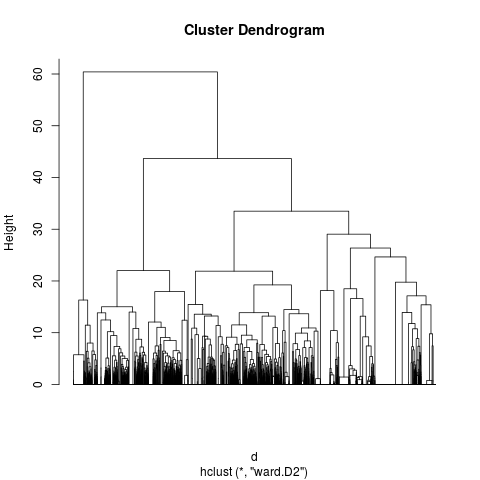

In [182]:
%%R -o texts_1

library(data.table)
library(cluster)
library(factoextra)
library(ggplot2)
library(proxy)

setwd('/home/mquezada/phd/multimedia-summarization/_new/data/vectors/')
set.seed(123)

vectors <- fread('spain_vectors_full.tsv', sep='\t', header=F)
docs <- fread('spain_doc_ids_full.tsv', sep='\t', header=F)
texts <- fread('spain_tweets_full.tsv', sep='\t', header=F)

d <- dist(vectors, method='euclidean')
hc <- hclust(d, method = 'ward.D2')
plot(hc, hang=-1, labels = F)

labels <- cutree(hc, k=2)
docs.f <- docs[labels == 1]
texts_1 <- texts[docs.f, on="V1"]

In [185]:
%%R -o texts_1
docs.f <- docs[labels == 2]
texts_1 <- texts[docs.f, on="V1"]

In [186]:
label_1 = pandas2ri.ri2py(texts_1)[["V2"]]
label_1["V2"].value_counts().to_csv('label2.txt')
# label_1.to_csv('label1.txt')